# PyTorch Tutorial - Part 2

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Get accustomed to the basics of pytorch 
* Do simple operations

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


Generate data coming from a simple polynomial and corrupt with noise

In [2]:
np.random.seed(0)

x = np.arange(-2, 5, 0.1)
y = x**3 - 4*x**2 - 2*x + 2
y_noise = y + np.random.normal(0, 1.5, size=(len(x),))

In [3]:
# simple function to get a random mini-batch
def get_batch(x, y, batch_size=20):
    idxs = np.random.randint(0, len(x), (batch_size))
    return x[idxs], y[idxs]

Define graph by model, use 2 hidden layers, one with ReLU and the other one with tanh activation (overkill for this example, but for illustration purposes).

In [4]:
num_iter = 100*300
image_cycle = 300

mini_batch_size = 10

neurons_H1 = 4
neurons_H2 = 5

      
# contains all the x values. We need to expand the dimensions of the input tensor    
x_eval_tensor = torch.from_numpy(np.expand_dims(x,1)).float().to(device)
    
# predefined linear layers, parameters are input and output neurons
layer1 = torch.nn.Linear(1, neurons_H1).to(device)
layer2 = torch.nn.Linear(neurons_H1, neurons_H2).to(device) 
layer3 = torch.nn.Linear(neurons_H2, 1, bias=False).to(device) # do not use bias on final layer

# Activation function
activation_function = torch.nn.Tanh()


# gather parameters of both layers
parameters = list(layer1.parameters()) + list(layer2.parameters()) + list(layer3.parameters())

# Adam and MSE Loss
optimizer = torch.optim.Adam(parameters)
loss_fn = torch.nn.MSELoss(reduction='mean')

Main loop of learning. Calculate output of a batch, compute loss and respective gradients, the do the optimization. Import is to reset the gradients after each step.

In [8]:
# main loop    
y_est_save = np.zeros((num_iter // image_cycle, len(y)))

save_idx = 0
for step in range(num_iter):    
    batch_x, batch_y = get_batch(x,y_noise, mini_batch_size)
    x_train_tensor = torch.from_numpy(np.expand_dims(batch_x,1)).float().to(device)
    y_train_tensor = torch.from_numpy(np.expand_dims(batch_y,1)).float().to(device)
    
    
    yhat = layer3(activation_function(layer2(activation_function(layer1(x_train_tensor)))))
    
    loss = loss_fn(yhat, y_train_tensor)
        
    # compute gradients
    loss.backward() 
        
    # carry out one optimization step with Adam
    optimizer.step()
        
    # reset gradients to zero
    optimizer.zero_grad()
    
    if step % image_cycle == 0:
        y_est = layer3(activation_function(layer2(activation_function(layer1(x_eval_tensor)))))
        y_est_save[save_idx,:] = y_est.detach().cpu().numpy().flatten()
        save_idx += 1
    

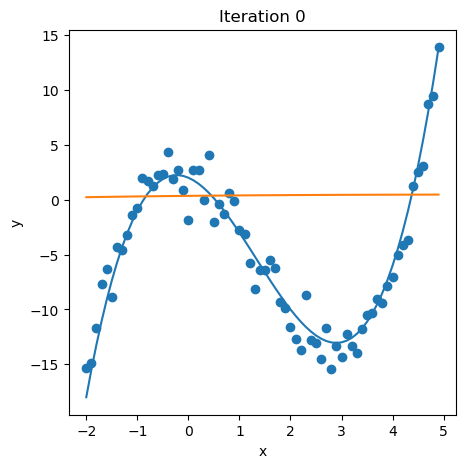

In [13]:
%matplotlib inline


fig,ax = plt.subplots(1,1,figsize=(5,5))        

# plot result of learning
    
def animate(i):
    ax.clear()
    
    ax.scatter(x, y_noise)
    ax.plot(x, y)
    ax.plot(x, y_est_save[i,:])
    ax.set_xlabel('x')
    ax.set_ylabel('y')    
    ax.set_title('Iteration %d' % (i * image_cycle))

anim = animation.FuncAnimation(fig, animate, frames=num_iter//image_cycle, interval=100, blit=False)
#anim.save('pytorch_tutorial.gif', writer=PillowWriter(fps=20))

from IPython.display import HTML
HTML(anim.to_jshtml())